<a href="https://colab.research.google.com/github/GiannisMitr/CNN-Neural-Style-Transfer/blob/master/dqn_atari_breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network implementation

This notebook implements a DQN - an approximate q-learning algorithm with experience replay and target networks. Trains the algorithm on openAI's gym, to breakout Atari game, and monitors its games by exporting videos.

The code was developed as part of [Practical Reinforcement Learning](https://https://www.coursera.org/learn/practical-rl) course on Coursera.



In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

bash: ../xvfb: No such file or directory
env: DISPLAY=:1


In [0]:
#Make necessary imports
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box

# from scipy.misc import imresize
import cv2

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""
        
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        
        # resize image
        img = cv2.resize(img, self.img_size)
        
        img = img.mean(-1,keepdims=True)
        
        img = img.astype('float32') / 255.
              
        return img


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images.


In [0]:
from gym.spaces.box import Box
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            """Multiply channels dimension by number of frames"""
            obs_shape = [height, width, n_channels * n_frames] 
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)


In [0]:

def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

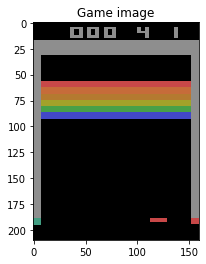

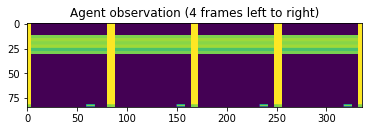

In [6]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless we have an array of GPUs. Instead, we can use strided convolutions with a small number of features to save time and memory.

In [7]:
#Import TensorFlow and Keras
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, InputLayer

tf.reset_default_graph()
sess = tf.InteractiveSession()



Using TensorFlow backend.


In [0]:
from keras.layers import Conv2D, Dense, Flatten
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = keras.models.Sequential()
    
            # Keras ignores the first dimension in the input_shape, which is the batch size. 
            # So just use state_shape for the input shape
            self.network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Flatten())
            self.network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [9]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

In [0]:
#Evaluate agents performance, in a number of games
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    s = env.reset()
    for _ in range(n_games):
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
         
            reward += r
            if done: 
              s = env.reset()
              break
          
        
        rewards.append(reward)
    return np.mean(rewards)

### Experience replay
#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [0]:
# This code is shamelessly stolen from https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


In [0]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    reward = 0.0
    for t in range(n_steps):
        # get agent to pick action given state s
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        # add to replay buffer
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward
        
    

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$




In [0]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [0]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)
    


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [0]:
# Create placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [0]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [17]:
# compute q-values for NEXT states with target network
next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# Define loss function for sgd.
# td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(tf.losses.huber_loss(labels=reference_qvalues, predictions=current_action_qvalues))

optimizer=tf.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(td_loss, var_list=agent.weights)

sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Main loop

It's time to put everything together and see if it learns anything.

In [0]:
#Uncomment to load stored weights of trained agent.
#agent.network.load_weights('dqn_model_atari_weights.h5')

In [0]:
#Create the buffer and fill it.
exp_replay = ReplayBuffer(70000)
play_and_record(agent, env, exp_replay, n_steps=10000)

# take a sample batch of observations from the buffer
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

buffer size = 70000, epsilon = 0.94646


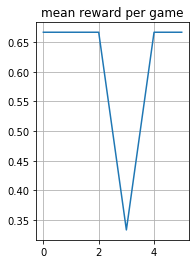

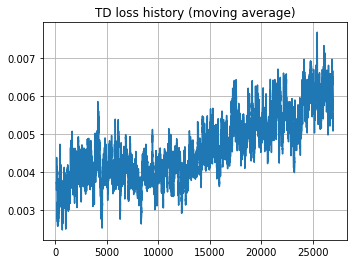

 27%|██▋       | 27103/100000 [17:23<43:54, 27.67it/s]

In [0]:
##Train the agent, configure the starting epsilon to one to encourage exploration
agent.epsilon=1
for i in trange(100000):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train the network
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        # reduce epsilon in every iteration until it reaches 1%
        agent.epsilon = max(agent.epsilon * 0.999, 0.01)

    
    if i % 5000 == 0:
      #uncomment to store agent's weights every some iterations
#         agent.network.save_weights('/dqn_model_atari_weights.h5')
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        
    if i % 500 == 0:
        # plot mean reward per game and TD loss history
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

        

__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.


__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 10k steps

### Video

In [0]:

# Don't forget to reset epsilon back to previous value if you want to go on training
agent.epsilon=0


In [0]:
#record session on a video
import gym.wrappers
#configure directory to store videos
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)

#load stored weights of trained agent.
!wget --no-check-certificate \
    https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_model_atari_weights.h5?raw=true \
    -O /tmp/dqn_model_atari_weights.h5
agent.network.load_weights('/tmp/dqn_model_atari_weights.h5')

sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(1)]
env_monitor.close()

In [20]:
#view a stored video of a trained agent
%%HTML
<video "640" height="480" controls>
  <source src="https://raw.githubusercontent.com/GiannisMitr/DQN-Atari-Breakout/master/trained-agent-game.mp4" type="video/mp4">
</video>